In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

In [7]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), "../../../filecoin-mecha-twin"))
import sys
sys.path.append(code_dir)

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

## 1. Parameters and other variables

In [4]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

SIM_START_LAG_DAYS = 10
# set the simulation start date
current_date = datetime.datetime.now().date() - datetime.timedelta(days=SIM_START_LAG_DAYS)
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast is one year ahead from today
forecast_lenght = 365*2
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-11-20
2024-11-19


## 2. Input data

#### Sector scheduled expirations

In [5]:
res = get_sector_expiration_stats(start_date, current_date,end_date)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

#### Daily network stats

In [6]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
current_day_stats

circulating_fil               393995877.934342
mined_fil                     239034785.684966
vested_fil                    306857607.124712
locked_fil                    135288055.073639
burnt_fil                       33675078.76347
date                                2022-11-20
total_raw_power_eib                  15.744799
total_qa_power_eib                   18.846074
day_onboarded_rb_power_pib            7.623535
day_onboarded_qa_power_pib           29.874701
day_renewed_qa_power_pib             37.204064
Name: 614, dtype: object

## 3. Choose Power Forecasting Scenario

In [74]:
scenario = 'optimistic-smooth'

if scenario == 'optimistic':
    scenario_params = curated.forecast_optimistic_scenario(forecast_lenght)
    plt_title_str = "Optimistic Scenario"
elif scenario == 'optimistic-smooth':
    scenario_params = curated.forecast_optimistic_scenario_smooth(forecast_lenght)
    plt_title_str = "Optimistic Scenario - Smooth Increase"
elif scenario == 'pessimistic':
    scenario_params = curated.forecast_pessimistic_scenario(forecast_lenght)
    plt_title_str = "Pessimistic Scenario"
elif scenario == 'pessimistic-smooth':
    scenario_params = curated.forecast_pessimistic_scenario_smooth(forecast_lenght)
    plt_title_str = "Pessimistic Scenario - Smooth Decrease"
else:
    raise ValueError("Unsupported scenario!")

In [75]:
_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)

In [76]:
# finalize inputs to the power forecasting module
renewal_rate_vec_pred = scenario_params['renewal_rate']
renewal_rate_vec = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred])    
rb_onboard_power_pred = scenario_params['rb_onboard_power']
fil_plus_rate_pred = scenario_params['filplus_rate']

duration = 360

## 2. Forecast power stats

In [77]:
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power_pred,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate_vec[-int(forecast_lenght):],
    fil_plus_rate_pred,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [78]:
power_df = build_full_power_stats_df(
    fil_stats_df,
    rb_power_df,
    qa_power_df,
    start_date,
    current_date,
    end_date,
)

## 3. Forecast Vesting

In [79]:
vest_df = compute_vesting_trajectory_df(start_date, end_date)

## 4. Forecast minting stats and baseline

In [80]:
rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

mint_df = compute_minting_trajectory_df(
    start_date,
    end_date,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
)

## 5. Baseline crossing

In [81]:
assert len(power_df) == len(mint_df)
assert power_df.iloc[0]['date'] == mint_df.iloc[0]['date']

# BASELINE_B0 = 2.88888888 # should be this
BASELINE_B0 = 2.7636 # this value is required to match sentinel
BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
EPOCH_PER_DAY = 2880
def baseline_storage(epoch: float)->float:
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

baseline_df = pd.DataFrame({
    'date': mint_df.date,
    'baseline_storage': baseline_storage(mint_df.days * EPOCH_PER_DAY)}
)

rb_crossing_above = power_df[power_df["total_raw_power_eib"] > baseline_df['baseline_storage']]["date"].iloc[0]
power_df_afterfirstcrossing = power_df[power_df['date'] > pd.to_datetime(rb_crossing_above)]
baseline_df_afterfirstcrossing = baseline_df[baseline_df['date'] > pd.to_datetime(rb_crossing_above)]
rb_crossing_below_df = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_raw_power_eib"] < baseline_df_afterfirstcrossing["baseline_storage"]]
if len(rb_crossing_below_df) > 0:
    rb_crossing_below = rb_crossing_below_df["date"].iloc[0]
else:
    rb_crossing_below = None
qa_crossing_below_df = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_qa_power_eib"] < baseline_df_afterfirstcrossing["baseline_storage"]]
if len(qa_crossing_below_df) > 0:
    qa_crossing_below = qa_crossing_below_df["date"].iloc[0]
else:
    qa_crossing_below = None

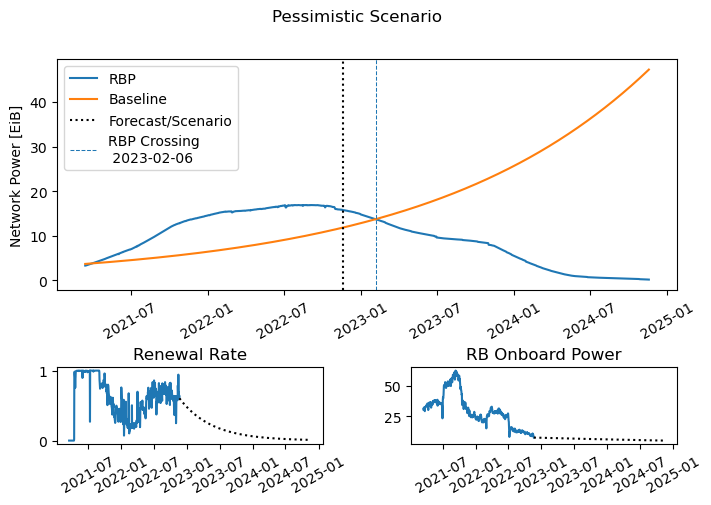

In [82]:
plt.figure(figsize=(8,5))
grid = plt.GridSpec(3, 4, wspace=1, hspace=1)

plt.subplot(grid[0:2, 0:4])
plt.plot(power_df.date, power_df.total_raw_power_eib, label='RBP')
# plt.plot(power_df.date, power_df.total_qa_power_eib, label='QAP')
plt.plot(mint_df.date, baseline_storage(mint_df.days * EPOCH_PER_DAY), label='Baseline')
plt.axvline(current_date, color='k', linestyle=':', label='Forecast/Scenario')
if rb_crossing_below is not None:
    plt.axvline(rb_crossing_below, linestyle='--', lw=0.75, label='RBP Crossing \n %s' % (rb_crossing_below,))
plt.xticks(rotation=30)
plt.legend(loc='upper left')
plt.ylabel('Network Power [EiB]')

t_cur = power_df[power_df['date'] >= current_date]
plt.subplot(grid[2,0:2])
plt.plot(fil_stats_df.date, historical_renewal_rate)
plt.plot(t_cur.date, renewal_rate_vec[len(historical_renewal_rate):], color='k', linestyle=':')
plt.xticks(rotation=30)
plt.title('Renewal Rate')

plt.subplot(grid[2,2:4])
plt.plot(fil_stats_df.date, fil_stats_df['day_onboarded_rb_power_pib'])
if isinstance(rb_onboard_power_pred, numbers.Number):
    plt.plot(t_cur.date, np.ones(forecast_lenght)*rb_onboard_power_pred, color='k', linestyle=':')
else:
    plt.plot(t_cur.date, rb_onboard_power_pred, color='k', linestyle=':')
plt.title('RB Onboard Power')
plt.xticks(rotation=30)

plt.suptitle(plt_title_str)
plt.tight_layout()